<a href="https://colab.research.google.com/github/ivandhernandez/cifar10-project/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Importing all necessary libraries needed
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset as Dataset
import os
from PIL import Image
import numpy as np
import pandas as pd


The [normalization](https://forums.fast.ai/t/image-normalization-in-pytorch/7534/7?u=laochanlam)

In [34]:
transform = transforms.Compose([
    transforms.ToTensor()])

# Load the CIFAR10 Training set 
train_set = torchvision.datasets.CIFAR10(root = './data', train = True,
                                         download = True, transform = transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Call DataLoader objects to efficiently access our data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

# 0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
pop_mean = []
pop_std0 = []
pop_std1 = []
for i, data in enumerate(test_loader, 0):
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0) 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = pop_mean, std = pop_std1)
])

In [11]:
# Load the CIFAR10 Training set 
train_set = torchvision.datasets.CIFAR10(root = './data', train = True,
                                         download = True, transform = transform)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Call DataLoader objects to efficiently access our data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


Image Size: torch.Size([3, 32, 32])


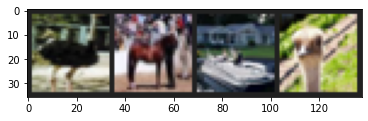

    2     7     8     2


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an Image
def imshow(img):
  # (x - mean(x)/ std)
    img = img * pop_std1 + pop_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get random training mage
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('Image Size: {}'.format(images[0].shape))
# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
# Defining the hyperparameters
input_size = 32*32*3 # img_size = (3, 32, 32)
hidden_size = 500    # how to know the optimal size for hidden layer
num_classes = 10     # same class
num_epochs = 5       # number of times to go through the training dataset
# batch_size = 4 **batch_size is handled in the dataloader
lr = 1e-3            # **learning rate (vs batch size & # of epoch) to get good accuracy

### Network Architecture

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Creating a 1-Layer Neural Network called Net
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    
  # Define the order of forward propagation
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [16]:
# Load the network and put it on the GPU if available
net = Net(input_size, hidden_size, num_classes)

if torch.cuda.is_available():
  net.cuda()
  print('CUDA: OK')
# Print the network 
print(net)

CUDA: OK
Net(
  (fc1): Linear(in_features=3072, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [18]:
# Define our loss function and instantiate Adam optimizer
loss_function = nn.CrossEntropyLoss()
# Chose Adam optimizer -- adaptive learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

## Training Loop

In [21]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

# Iterate through all Epochs
loss_list = []

# Neural Network Training Loop
for epoch in range(num_epochs):
  # Iterate through training dataset
  running_loss = 0.0
  for i , data in enumerate(train_loader, 0):
    print(i)
    # Flatten images and load images/labels onto GPU
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    # Zero collected gradients at each step
    optimizer.zero_grad()
    # Forward Propagate
    outputs = net(images.view(-1, input_size))
    # Calculate Loss
    loss = loss_function(outputs, labels)
    # Back propagate
    loss.backward()
    # Update weights
    optimizer.step()
    
    # Print statistics on every 100th iteration
    running_loss += loss.item()

    print("i: ", i, "run_loss: ", running_loss)

    # Originally % 2000
    if (i+1) % 500 == 0:
      loss_list.append(running_loss / 500)
      print('Epoch [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, running_loss / 500))
      running_loss = 0.0

Streaming output truncated to the last 5000 lines.
i:  10002 run_loss:  5.038840174674988
10003
i:  10003 run_loss:  7.908614993095398
10004
i:  10004 run_loss:  11.07922089099884
10005
i:  10005 run_loss:  12.154599905014038
10006
i:  10006 run_loss:  13.736148834228516
10007
i:  10007 run_loss:  14.441425442695618
10008
i:  10008 run_loss:  17.373316407203674
10009
i:  10009 run_loss:  28.46720564365387
10010
i:  10010 run_loss:  30.005862832069397
10011
i:  10011 run_loss:  31.827813982963562
10012
i:  10012 run_loss:  32.3434739112854
10013
i:  10013 run_loss:  33.742146134376526
10014
i:  10014 run_loss:  35.68285357952118
10015
i:  10015 run_loss:  36.410529375076294
10016
i:  10016 run_loss:  37.300453186035156
10017
i:  10017 run_loss:  38.63583028316498
10018
i:  10018 run_loss:  41.776114106178284
10019
i:  10019 run_loss:  43.04809868335724
10020
i:  10020 run_loss:  43.595092952251434
10021
i:  10021 run_loss:  44.39777499437332
10022
i:  10022 run_loss:  45.64082533121109


In [20]:
loss_list

[2.309979271411896,
 2.0992703812122344,
 2.0717820637226105,
 2.057431067585945,
 1.9853143781423568,
 1.9984782376289367,
 1.9941489552259446,
 1.903793773174286,
 1.9296584397554397,
 1.8909363256692886,
 1.878551486492157,
 2.01336509001255,
 1.9334425338506698,
 1.940444473862648,
 1.8641774267554283,
 1.8843551182746887,
 2.062590812921524,
 1.8830422662496566,
 1.8878944990634918,
 1.8766606478691101,
 2.0103967034816743,
 1.93363929104805,
 1.8719209650754929,
 1.8862148385047912,
 2.2633334481716156,
 1.9924717725515366,
 1.8544835914373399,
 1.9072722103595734,
 1.8779409536123275,
 1.9040930891036987,
 1.8717401132583618,
 1.8490683678388595,
 1.8556275146007537,
 1.8785718593597411,
 1.8482617456912995,
 2.0190705169439314,
 1.9107051560878754,
 1.8329952939748764,
 1.7946090200543403,
 1.9847357181310654,
 1.9969264253377914,
 1.8789884767532348,
 2.0589342222213745,
 1.9071389336585998,
 1.839897565960884,
 1.856196443915367,
 1.8204888373613357,
 1.8930606805086136,
 2.1

### Measure Model Accuracy

In [41]:
def validate(model, train_loader, test_loader):
    for name, loader in [("train", train_loader), ("val", test_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # since we dont want to update the parameters
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(images.view(-1, input_size))
                _, predicted = torch.max(outputs, dim=1) # index of highest value as output
                total += labels.shape[0] # counts the number of examples so total is increased by the batch size
                correct += int((predicted == labels).sum())
                # Comparing the predicted class that had the
                # maximum probability and the ground-truth
                # labels, we first get a Boolean array. Taking the
                # sum gives the number of items in the batch
                # where the prediction and ground truth agree.
                
            print("Accuracy {}: {:.2f}".format(name, correct/total))

In [40]:
validate(net, train_loader, test_loader)

Accuracy train: 0.10
Accuracy val: 0.10


In [35]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images.view(-1, input_size))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network all test images: %d %%' % (
    100 * correct / total))

Accuracy of the network all test images: 19 %
